In [141]:
#import beautiful soup for web scraping the wiki page of Toronto
from bs4 import BeautifulSoup
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import requests
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn import datasets

In [10]:
#import Hospital data and filter only ICUs beds
df_hosp = pd.read_csv(r'C:\Users\giaco\Documents\GitHub\Letti_per_struttura_sanitaria_di_ricovero.csv')

df_ICU=df_hosp.loc[df_hosp['DESCR_DISCIPLINA'] == "TERAPIA INTENSIVA"].reset_index(drop=True)
df_ICUclean=df_ICU.drop(['ANNO', 'ASL', 'COD_ENTE', 'COD_STRUTTURA', 'COD_SUB',
        'COD_TIPO_STR', 'DESCR_TIPO_STR', 'PUBBL_PRIV',
       'COD_DISCIPLINA',  'AREA', 'TIPO_DEGENZA',
       'MESI_DEG_ORD', 'MEDIA_LETTI_DEG_ORD',
       'MESI_DH', 'MEDIA_LETTI_DH_DS','Posti_letto_DH_DS_attivati_al_31_12'], axis='columns')
df_ICUclean

,PROVINCIA,DENOM_STRUTTURA,DESCR_DISCIPLINA,Posti_letto_ORD_attivati_al_31_12
0,MI,OSPEDALE CIVILE DI LEGNANO,TERAPIA INTENSIVA,34.0
1,CO,OSPEDALE S. ANNA - COMO,TERAPIA INTENSIVA,35.0
2,MI,CASA DI CURA IGEA - MILANO,TERAPIA INTENSIVA,4.0
3,CO,OSPEDALE S. ANTONIO ABATE - CANTU',TERAPIA INTENSIVA,10.0
4,MB,PRESIDIO OSPEDALIERO DI CARATE,TERAPIA INTENSIVA,5.0
...,...,...,...,...
86,MN,OSP.CIVILE DESTRA SECCHIA-PIEVE CORIANO,TERAPIA INTENSIVA,4.0
87,BS,OSPEDALE DI MANERBIO,TERAPIA INTENSIVA,11.0
88,MI,OSPEDALE S. MARIA DELLE STELLE MELZO,TERAPIA INTENSIVA,5.0
89,MI,"CENTRO CARDIOLOGICO ""FOND. MONZINO"" - MILANO",TERAPIA INTENSIVA,0.0


In [46]:
#Change Province abbr with full name
df_ICUclean.loc[(df_ICUclean.PROVINCIA == 'MI'),'PROVINCIA']='Milano'
df_ICUclean.loc[(df_ICUclean.PROVINCIA == 'CO'),'PROVINCIA']='Como'
df_ICUclean.loc[(df_ICUclean.PROVINCIA == 'BS'),'PROVINCIA']='Brescia'
df_ICUclean.loc[(df_ICUclean.PROVINCIA == 'MB'),'PROVINCIA']='Monza e Brianza'
df_ICUclean.loc[(df_ICUclean.PROVINCIA == 'MN'),'PROVINCIA']='Mantova'
df_ICUclean.loc[(df_ICUclean.PROVINCIA == 'BG'),'PROVINCIA']='Bergamo'
df_ICUclean.loc[(df_ICUclean.PROVINCIA == 'VA'),'PROVINCIA']='Varese'
df_ICUclean.loc[(df_ICUclean.PROVINCIA == 'LO'),'PROVINCIA']='Lodi'
df_ICUclean.loc[(df_ICUclean.PROVINCIA == 'CR'),'PROVINCIA']='Cremona'
df_ICUclean.loc[(df_ICUclean.PROVINCIA == 'LC'),'PROVINCIA']='Lecco'
df_ICUclean.loc[(df_ICUclean.PROVINCIA == 'PV'),'PROVINCIA']='Pavia'
df_ICUclean.loc[(df_ICUclean.PROVINCIA == 'SO'),'PROVINCIA']='Sondrio'
#Check if there is some broken data 
df_ICUclean['Posti_letto_ORD_attivati_al_31_12'].unique()
df_ICUclean = df_ICUclean.dropna()
df_ICUclean.reset_index(drop=True)
prov=df_ICUclean['PROVINCIA'].unique()
df_ICUclean

,PROVINCIA,DENOM_STRUTTURA,DESCR_DISCIPLINA,Posti_letto_ORD_attivati_al_31_12
0,Milano,OSPEDALE CIVILE DI LEGNANO,TERAPIA INTENSIVA,34.0
1,Como,OSPEDALE S. ANNA - COMO,TERAPIA INTENSIVA,35.0
2,Milano,CASA DI CURA IGEA - MILANO,TERAPIA INTENSIVA,4.0
3,Como,OSPEDALE S. ANTONIO ABATE - CANTU',TERAPIA INTENSIVA,10.0
4,Monza e Brianza,PRESIDIO OSPEDALIERO DI CARATE,TERAPIA INTENSIVA,5.0
...,...,...,...,...
83,Mantova,OSP.CIVILE DESTRA SECCHIA-PIEVE CORIANO,TERAPIA INTENSIVA,4.0
84,Brescia,OSPEDALE DI MANERBIO,TERAPIA INTENSIVA,11.0
85,Milano,OSPEDALE S. MARIA DELLE STELLE MELZO,TERAPIA INTENSIVA,5.0
86,Milano,"CENTRO CARDIOLOGICO ""FOND. MONZINO"" - MILANO",TERAPIA INTENSIVA,0.0


In [133]:
#Now We need to get the total number of ICU beds for each region
df_Beds=df_ICUclean.drop(['DENOM_STRUTTURA','DESCR_DISCIPLINA'],axis='columns')
df_Beds=df_Beds.groupby(['PROVINCIA']).size().reset_index(name='ICUBEDS')
df_Beds.columns = ['Province', 'IcuBeds']
df_Beds

,Province,IcuBeds
0,Bergamo,6
1,Brescia,13
2,Como,7
3,Cremona,3
4,Lecco,2
5,Lodi,2
6,Mantova,3
7,Milano,33
8,Monza e Brianza,5
9,Pavia,5


In [129]:
#Get all region population data
url = "https://it.wikipedia.org/wiki/Lombardia#Suddivisione_amministrativa"
req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')

table_contents=[]
tab=soup.find_all("table",{"class":"wikitable sortable"})
tab_pop=tab[5]
df_pop = pd.read_html(str(tab_pop))[0]

In [130]:
df_pop=df_pop.drop(['Superficie(km2)','Densità(ab./km2)','Comuni(n.)','Mappa'],axis='columns')
df_pop.columns = ['Province', 'Population']
df_pop

,Province,Population
0,Bergamo,1110457
1,Brescia,1262135
2,Como,599637
3,Cremona,358578
4,Lecco,337256
5,Lodi,229946
6,Mantova,411959
7,Milano,3233541
8,Monza e Brianza,871523
9,Pavia,545611


In [166]:
#Merge of population data and ICU BEDS by region
data_final=pd.merge(df_pop, df_Beds, on=['Province'])
data_final.columns = ['Province','Population' ,'ICU_Beds']
data_final

,Province,Population,ICU_Beds
0,Bergamo,1110457,6
1,Brescia,1262135,13
2,Como,599637,7
3,Cremona,358578,3
4,Lecco,337256,2
5,Lodi,229946,2
6,Mantova,411959,3
7,Milano,3233541,33
8,Monza e Brianza,871523,5
9,Pavia,545611,5


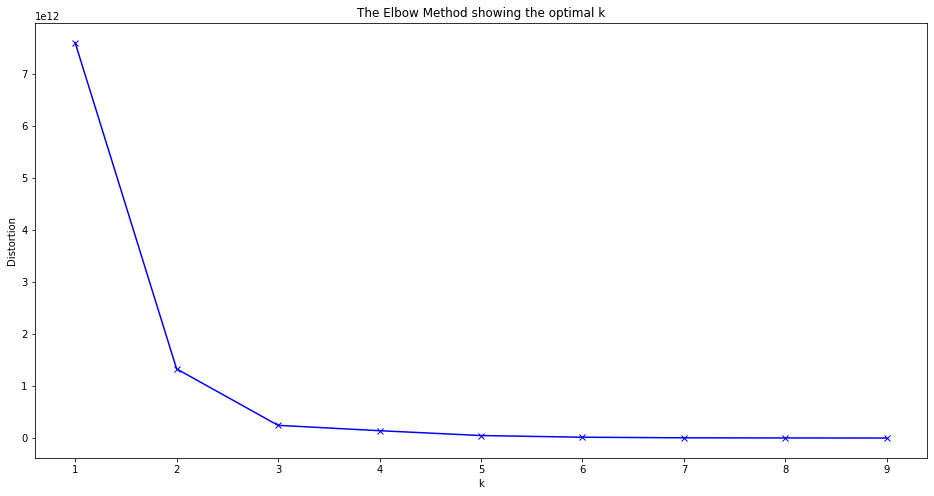

In [167]:
#Find the best k for kmeans
ICUclustering=data_final.drop(['Province'],axis='columns')
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(ICUclustering)
    distortions.append(kmeanModel.inertia_)
#Print distortions to find the best k with elbow method 
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [168]:
#We use 3 as K to define clusters
kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(ICUclustering)
kmeanModel.labels_[0:10]
#Add labels to datas 
data_final.insert(0,'Cluster_Labels',kmeanModel.labels_)
data_final

,Cluster_Labels,Province,Population,ICU_Beds
0,2,Bergamo,1110457,6
1,2,Brescia,1262135,13
2,0,Como,599637,7
3,0,Cremona,358578,3
4,0,Lecco,337256,2
5,0,Lodi,229946,2
6,0,Mantova,411959,3
7,1,Milano,3233541,33
8,2,Monza e Brianza,871523,5
9,0,Pavia,545611,5


In [182]:
data_vis=data_final.drop(['Province'],axis='columns')
data_vis

,Cluster_Labels,Population,ICU_Beds
0,2,1110457,6
1,2,1262135,13
2,0,599637,7
3,0,358578,3
4,0,337256,2
5,0,229946,2
6,0,411959,3
7,1,3233541,33
8,2,871523,5
9,0,545611,5


<function matplotlib.pyplot.show(close=None, block=None)>

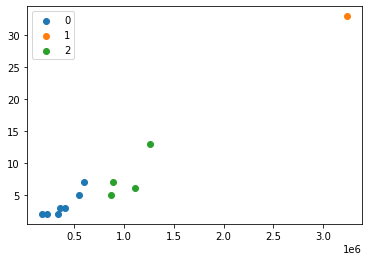

In [195]:
data_C1=data_vis.loc[data_vis['Cluster_Labels'] == 0]
data_C2=data_vis.loc[data_vis['Cluster_Labels'] == 1]
data_C3=data_vis.loc[data_vis['Cluster_Labels'] == 2]


u_labels = data_vis['Cluster_Labels'].unique()

 
#plotting the results:
 
plt.scatter(data_C1['Population'] , data_C1['ICU_Beds'], label = 0)
plt.scatter(data_C2['Population'] , data_C2['ICU_Beds'], label = 1)
plt.scatter(data_C3['Population'] , data_C3['ICU_Beds'], label = 2)
plt.legend()
plt.show